## Balanced Approach Rule and Balanced-approach (Shortfalls) Rule
By Nathan Ramos, CFA

The Balanced Approach Rule and its variant, the Balanced-approach (Shortfalls) Rule, are monetary policy guidelines that adjust nominal interest rates based on deviations in inflation and unemployment. These rules, differing from the traditional Taylor Rule, significantly emphasize unemployment metrics, with the Balanced-approach (Shortfalls) Rule specifically targeting employment shortfalls to provide stimulus during severe economic downturns without overreacting to positive conditions.

In this notebook, using the pyeconomics package, we will compute and analyze these interest rates using real-time and historical data from the FRED database to see how these guidelines could influence monetary policy decisions.

## Importing Necessary Libraries
Before we begin the computations, we need to import the necessary libraries that will enable us to fetch data, perform calculations, and visualize results. This includes libraries for data manipulation, API access, and plotting.

In [1]:
# Import standard libraries
import os
import sys

# Configure system path
sys.path.insert(0, os.path.abspath('../../'))

# Import third-party libraries
import pandas as pd
import matplotlib.pyplot as plt

# Import pyeconomics module
import pyeconomics as pyecon

# Set up display for plots in a Jupyter notebook
%matplotlib inline

## Configuring API Access to FRED
To leverage the real-time data fetching capabilities of the pyeconomics package for Taylor Rule calculations, configure your FRED API access by securely setting up your API key. A detailed step-by-step guide on obtaining and securely storing your FRED API key with the keyring library is available in our dedicated notebook, ensuring compliance with FRED's security policies and preventing unauthorized access.

## FRED Series IDs for Economic Data
In this section, we define the series identifiers (IDs) used to fetch economic data from the FRED (Federal Reserve Economic Data) database, crucial for the calculations of the Balanced Approach Rule and its variant, the Balanced-approach (Shortfalls) Rule. These identifiers allow users to select specific data series that align with their analytical needs or data availability. The IDs provided below correspond to key economic indicators relevant to both rules:

In [2]:
# FRED Series IDs for economic data
inflation_series_id = 'PCETRIM12M159SFRBDAL'
unemployment_rate_series_id = 'UNRATE'
natural_unemployment_series_id = 'NROU'
real_interest_rate_series_id = 'DFII10'

# Print the series names and their IDs
print(f"Inflation Series ID:               {pyecon.fred_client.get_series_name(inflation_series_id)}")
print(f"Unemployment Rate Series ID:       {pyecon.fred_client.get_series_name(unemployment_rate_series_id)}")
print(f"Natural Unemployment Series ID:    {pyecon.fred_client.get_series_name(natural_unemployment_series_id)}")
print(f"Real Interest Rate Series ID:      {pyecon.fred_client.get_series_name(real_interest_rate_series_id)}")

Inflation Series ID:               Trimmed Mean PCE Inflation Rate
Unemployment Rate Series ID:       Unemployment Rate
Natural Unemployment Series ID:    Noncyclical Rate of Unemployment
Real Interest Rate Series ID:      Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis, Inflation-Indexed


## Model Assumptions and Parameters
This section outlines the assumptions and parameters used in the Balanced Approach Rule calculation. These values can be adjusted to simulate different economic conditions and policy responses:

In [3]:
# Model Assumptions
inflation_target = 2.0
alpha = 0.5
beta = 2.0
rho = 0.70
elb = 0.125
apply_elb = True
verbose = True
include_ai_analysis = True

## Current Balanced Approach Rule Calculation Using the FRED API
This section demonstrates the computation of the current recommended interest rate according to the Balanced Approach Rule, utilizing real-time economic indicators fetched directly from the FRED (Federal Reserve Economic Data) API. Ensure that your API credentials are correctly configured to fetch this data.

In [4]:
# Current Balanced Approach Rule calculation
indicators = pyecon.EconomicIndicators(
    inflation_series_id=inflation_series_id,
    unemployment_rate_series_id=unemployment_rate_series_id,
    natural_unemployment_series_id=natural_unemployment_series_id,
    real_interest_rate_series_id=real_interest_rate_series_id
)
params = pyecon.BalancedApproachRuleParameters(
    inflation_target=inflation_target,
    alpha=alpha,
    beta=beta,
    rho=rho,
    elb=elb,
    apply_elb=apply_elb,
    use_shortfalls_rule=False,
    verbose=verbose,
    include_ai_analysis=include_ai_analysis
)

current_bar_rate_fred = pyecon.balanced_approach_rule(indicators, params)


==== Economic Indicators =============================================
  Current Inflation:                             2.79%
  Target Inflation:                              2.00%
  Current Unemployment Rate:                     4.00%
  Natural Unemployment Rate:                     4.41%
  Long-Term Real Interest Rate:                  2.03%
  Current Fed Rate:                              5.50%
  As of Date:                                    June 30, 2024

==== Gaps ============================================================
  Inflation Gap:                                 0.79%
  Unemployment Gap:                              0.41%

==== Balanced Approach Rule ==========================================
  Long-Term Real Interest Rate:                  2.03%
  Current Inflation:                             + 2.79%
  Alpha * Inflation Gap:                         + 0.50 * 0.79%
  Beta * Unemployment Gap:                       + 2.00 * 0.41%
-----------------------------------------

## Current Balanced-approach (Shortfalls) Rule Calculation Using the FRED API
This section demonstrates the computation of the current recommended interest rate according to the Balanced-approach (Shortfalls) Rule, utilizing real-time economic indicators fetched directly from the FRED (Federal Reserve Economic Data) API. Ensure that your API credentials are correctly configured to fetch this data.

In [5]:
# Current Balanced Approach (Shortfalls) Rule calculation
params.use_shortfalls_rule = True
current_basr_rate_fred = pyecon.balanced_approach_rule(indicators, params)


==== Economic Indicators ==============================================
  Current Inflation:                             2.79%
  Target Inflation:                              2.00%
  Current Unemployment Rate:                     4.00%
  Natural Unemployment Rate:                     4.41%
  Long-Term Real Interest Rate:                  2.03%
  Current Fed Rate:                              5.50%
  As of Date:                                    June 30, 2024

==== Gaps =============================================================
  Inflation Gap:                                 0.79%
  Unemployment Shortfall Gap:                    0.00%

==== Balanced Approach Shortfalls Rule (BASR) =========================
  Long-Term Real Interest Rate:                  2.03%
  Current Inflation:                             + 2.79%
  Alpha * Inflation Gap:                         + 0.50 * 0.79%
  Beta * Unemployment Gap:                       + 2.00 * 0.00%
--------------------------------------

## Setting Preset Economic Indicators for Stagflation Simulation
Users can manually input preset values for key economic indicators to compute the interest rate according to the Balanced Approach Rule (BAR) or the Balanced Approach Shortfalls Rule (BASR). These methods allow for simulations under specific economic scenarios such as stagflation, which is characterized by high inflation and unemployment alongside sluggish economic growth:

In [6]:
# Preset values for economic indicators in a stagflation scenario
indicators = pyecon.EconomicIndicators(
    current_inflation_rate=6.0,
    current_unemployment_rate=6.0,
    natural_unemployment_rate=4.5,
    long_term_real_interest_rate=2.0,
    current_fed_rate=8.0
)

# Current Balanced Approach Rule calculation
params.use_shortfalls_rule = False
current_bar_rate_preset = pyecon.balanced_approach_rule(indicators, params)


==== Economic Indicators =============================================
  Current Inflation:                             6.00%
  Target Inflation:                              2.00%
  Current Unemployment Rate:                     6.00%
  Natural Unemployment Rate:                     4.50%
  Long-Term Real Interest Rate:                  2.00%
  Current Fed Rate:                              8.00%
  As of Date:                                    June 30, 2024

==== Gaps ============================================================
  Inflation Gap:                                 4.00%
  Unemployment Gap:                              -1.50%

==== Balanced Approach Rule ==========================================
  Long-Term Real Interest Rate:                  2.00%
  Current Inflation:                             + 6.00%
  Alpha * Inflation Gap:                         + 0.50 * 4.00%
  Beta * Unemployment Gap:                       + 2.00 * -1.50%
---------------------------------------

In [7]:
# Current Balanced Approach (Shortfalls) Rule calculation
params.use_shortfalls_rule = True
current_basr_rate_preset = pyecon.balanced_approach_rule(indicators, params)


==== Economic Indicators ==============================================
  Current Inflation:                             6.00%
  Target Inflation:                              2.00%
  Current Unemployment Rate:                     6.00%
  Natural Unemployment Rate:                     4.50%
  Long-Term Real Interest Rate:                  2.00%
  Current Fed Rate:                              8.00%
  As of Date:                                    June 30, 2024

==== Gaps =============================================================
  Inflation Gap:                                 4.00%
  Unemployment Shortfall Gap:                    -1.50%

==== Balanced Approach Shortfalls Rule (BASR) =========================
  Long-Term Real Interest Rate:                  2.00%
  Current Inflation:                             + 6.00%
  Alpha * Inflation Gap:                         + 0.50 * 4.00%
  Beta * Unemployment Gap:                       + 2.00 * -1.50%
------------------------------------

## Policy Prescription Summary for Stagflation Scenario
In the stagflation scenario characterized by a high inflation rate of 6.00% and an unemployment rate of 6.00%, both the Balanced Approach Rule (BAR) and the Balanced Approach Shortfalls Rule (BASR) suggest similar policy responses. The calculations are based on an inflation gap of 4.00% and an unemployment gap of -1.50%. Starting with a long-term real interest rate of 2.00% and adjustments for current inflation and unemployment gaps, the initial unadjusted interest rate estimates for both rules are 7.00%. This is then compared against an effective lower bound (ELB) of 0.12%, maintaining the rate at 7.00%. Further adjustments are made for policy inertia with a coefficient of 0.70 and the current Federal Funds Rate of 8.00%, leading to a final adjusted policy interest rate of 7.70% for both rules. These calculations indicate a cautious yet responsive approach to monetary policy aimed at curbing inflation while considering the high unemployment, ensuring a balanced response to the economic distress characterized by high inflation and unemployment. This aims to preserve economic stability without exacerbating unemployment issues.

## Historical Balanced Approach Rule (BAR) and Balanced Approach Shortfalls Rule (BASR) Calculations
Now, we will compute the interest rates based on historical data sourced from the FRED API using both the Balanced Approach Rule (BAR) and the Balanced Approach Shortfalls Rule (BASR).

In [8]:
# Historical BAR calculation using FRED data
params.use_shortfalls_rule = False
historical_rates = pyecon.historical_balanced_approach_rule(indicators, params)
historical_rates.head()

,Inflation,UnemploymentRate,NaturalUnemploymentRate,RealInterestRate,FedRate,InflationGap,UnemploymentGap,BalancedApproachRule,AdjustedBalancedApproachRule
2003-01-02,2.08,5.8,5.1,2.43,1.25,0.08,-0.7,3.15,1.82
2003-01-03,2.08,5.8,5.1,2.43,1.25,0.08,-0.7,3.15,1.82
2003-01-04,2.08,5.8,5.1,2.43,1.25,0.08,-0.7,3.15,1.82
2003-01-05,2.08,5.8,5.1,2.43,1.25,0.08,-0.7,3.15,1.82
2003-01-06,2.08,5.8,5.1,2.46,1.25,0.08,-0.7,3.18,1.83


In [9]:
# Historical BASR calculation using FRED data
params.use_shortfalls_rule = True
historical_basr_rates = pyecon.historical_balanced_approach_rule(indicators, params)
historical_basr_rates.head()

,Inflation,UnemploymentRate,NaturalUnemploymentRate,RealInterestRate,FedRate,InflationGap,UnemploymentGap,BalancedApproachShortfallsRule,AdjustedBalancedApproachShortfallsRule
2003-01-02,2.08,5.8,5.1,2.43,1.25,0.08,-0.7,3.15,1.82
2003-01-03,2.08,5.8,5.1,2.43,1.25,0.08,-0.7,3.15,1.82
2003-01-04,2.08,5.8,5.1,2.43,1.25,0.08,-0.7,3.15,1.82
2003-01-05,2.08,5.8,5.1,2.43,1.25,0.08,-0.7,3.15,1.82
2003-01-06,2.08,5.8,5.1,2.46,1.25,0.08,-0.7,3.18,1.83


## Visualization of Historical BAR and BASR Data
Plotting the historical estimates from the Balanced Approach Rule (BAR) and Balanced Approach Shortfalls Rule (BASR) provides visual insights into how recommendations for monetary policy might have changed in response to economic indicators over time.

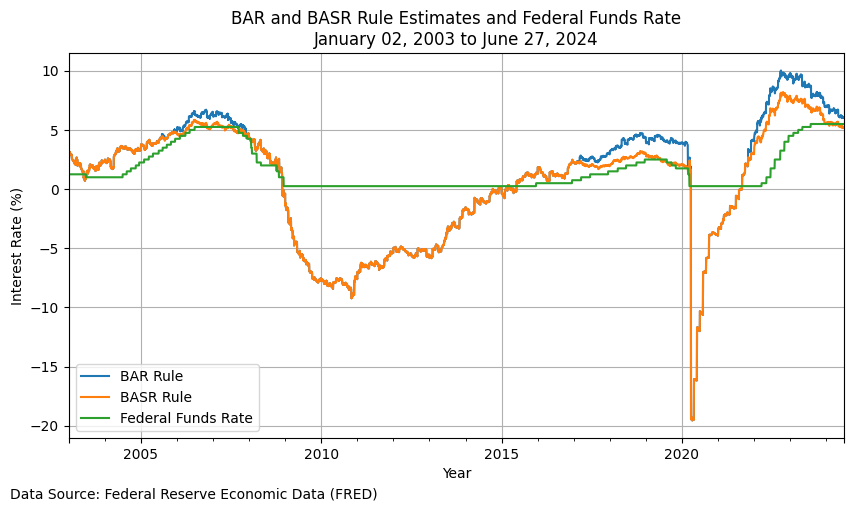

In [10]:
# Combine BAR and BASR historical rates
historical_rates_combined = pd.concat([historical_rates, historical_basr_rates], axis=1)
historical_rates_combined = historical_rates_combined.loc[:, ~historical_rates_combined.columns.duplicated()]

# Plot BAR and BASR Rule estimates
pyecon.plot_historical_bar_basr_rule(historical_rates_combined, adjusted=False)

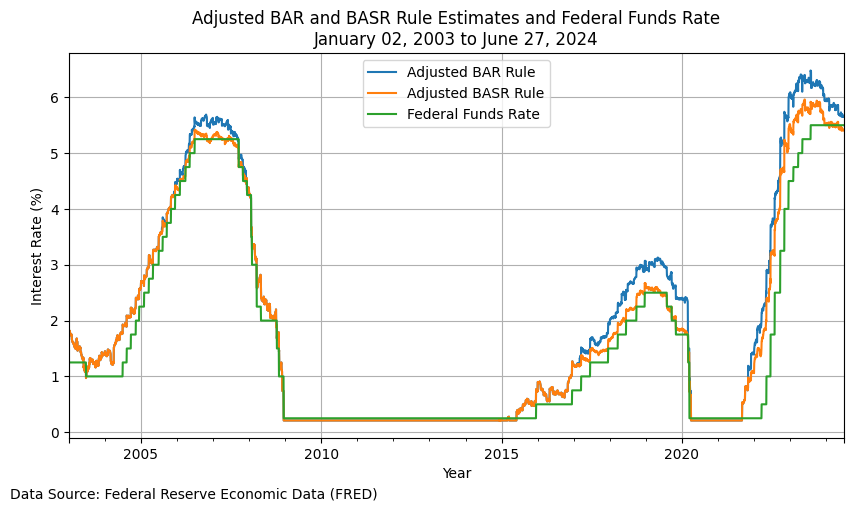

In [11]:
# Adjusted Historical BAR calculation using FRED data
params.rho = rho
params.apply_elb = apply_elb
params.use_shortfalls_rule = False
adj_historical_bar_rates = pyecon.historical_balanced_approach_rule(indicators, params)

# Adjusted Historical BASR calculation using FRED data
params.use_shortfalls_rule = True
adj_historical_basr_rates = pyecon.historical_balanced_approach_rule(indicators, params)

# Combine Adjusted BAR and BASR historical rates
adj_historical_rates_combined = pd.concat([adj_historical_bar_rates, adj_historical_basr_rates], axis=1)
adj_historical_rates_combined = adj_historical_rates_combined.loc[:, ~adj_historical_rates_combined.columns.duplicated()]

# Plot Adjusted BAR and BASR Rule estimates
pyecon.plot_historical_bar_basr_rule(adj_historical_rates_combined, adjusted=True)

## Conclusion
This notebook demonstrates the use of the pyeconomics package to calculate and visualize the Balanced Approach Rule (BAR) and the Balanced Approach Shortfalls Rule (BASR). These tools can aid economists, policymakers, and financial analysts in understanding and predicting central bank behavior regarding interest rates under varying economic conditions.